In [1]:
import fastf1
from fastf1.core import Session
fastf1.Cache.enable_cache('../data')
fastf1.Cache.offline_mode(True)

In [2]:
import pandas as pd
import numpy as np

In [3]:
import datetime

current_date = datetime.datetime.now()

In [4]:
# Get the event schedule for 2024
schedule_2024 = fastf1.get_event_schedule(2024)

# Convert 'EventDate' to datetime if it's not already
schedule_2024['EventDate'] = pd.to_datetime(schedule_2024['EventDate'])

# Filter events that have occurred before the current date
past_events_2024 = schedule_2024[schedule_2024['EventDate'] < current_date]

# Get the first event of 2023
event_2023_r1 = fastf1.get_event(2023, 1)  # First round of 2023

In [5]:
def get_weather_data(session: Session, type: str):
    weather_data = session.laps.get_weather_data()
    weather = weather_data[['AirTemp', 'Humidity', 'TrackTemp']].mean()
    weather = weather.rename({
        'AirTemp': f'{type}_AirTemp',
        'Humidity': f'{type}_Humidity',
        'TrackTemp': f'{type}_TrackTemp'
    })
    return weather


In [6]:
def process_qualifying(session: Session):
    # Get qualifying results
    qualifying_results = session.results

    # Select and rename qualifying features
    qualifying_features = qualifying_results[['DriverNumber', 'Position']].copy()
    qualifying_features.rename(columns={'Position': 'Position_Qualifying'}, inplace=True)

    # Check for 'Q1', 'Q2', 'Q3' columns and add if missing
    for q_col in ['Q1', 'Q2', 'Q3']:
        if q_col in qualifying_results.columns:
            qualifying_features[q_col] = qualifying_results[q_col]
        else:
            qualifying_features[q_col] = pd.NaT

    # Convert lap times to total seconds
    for col in ['Q1', 'Q2', 'Q3']:
        qualifying_features[col] = qualifying_features[col].apply(
            lambda x: x.total_seconds() if isinstance(x, pd.Timedelta) else (x if isinstance(x, (float, int)) else 999)
        )

    # Get average lap times for each driver in qualifying
    qualifying_laps = session.laps
    qualifying_laps = qualifying_laps[pd.notnull(qualifying_laps['LapTime'])]

    if not qualifying_laps.empty:
        qualifying_laps = qualifying_laps.copy()
        qualifying_laps['LapTime_seconds'] = qualifying_laps['LapTime'].dt.total_seconds()
        qualifying_avg_lap_times = qualifying_laps.groupby('DriverNumber')['LapTime_seconds'].mean().reset_index()
        qualifying_avg_lap_times.rename(columns={'LapTime_seconds': 'Qualifying_AvgLapTime'}, inplace=True)
    else:
        qualifying_avg_lap_times = pd.DataFrame(columns=['DriverNumber', 'Qualifying_AvgLapTime'])

    # Merge qualifying features with average lap times
    qualifying_features['DriverNumber'] = qualifying_features['DriverNumber'].astype(str)
    qualifying_avg_lap_times['DriverNumber'] = qualifying_avg_lap_times['DriverNumber'].astype(str)
    qualifying_features = pd.merge(qualifying_features, qualifying_avg_lap_times, on='DriverNumber', how='left')

    return qualifying_features



In [7]:
def get_telemetry_data(session: Session):
    telemetry_data_list = []
    for driver in session.drivers:
        try:
            # Get laps for the driver and pick the fastest lap
            driver_laps = session.laps.pick_drivers(driver)
            fastest_lap = driver_laps.pick_fastest()
            # Get car data (speed, throttle, brake, etc.)
            car_data = driver_laps.get_car_data()
            pos_data = driver_laps.get_pos_data()

            # Aggregate car data
            avg_speed = car_data['Speed'].mean()
            max_speed = car_data['Speed'].max()
            avg_throttle = car_data['Throttle'].mean()
            avg_brake = car_data['Brake'].mean()
            avg_rpm = car_data['RPM'].mean()
            avg_gear = car_data['nGear'].mean()
            max_rpm = car_data['RPM'].max()

            # Get telemetry data for the fastest lap
            telemetry = fastest_lap.get_telemetry()
            avg_speed = telemetry['Speed'].mean()
            avg_throttle = telemetry['Throttle'].mean()
            avg_brake = telemetry['Brake'].mean()

            # Status (OnTrack/OffTrack)
            on_track_percentage = pos_data['Status'].value_counts(normalize=True).get('OnTrack', 0) * 100


            # Append telemetry data for the driver
            telemetry_data_list.append({
                'DriverNumber': driver,
                'AvgSpeed': avg_speed,
                'MaxSpeed': max_speed,
                'AvgThrottle': avg_throttle,
                'AvgBrake': avg_brake,
                'AvgRPM': avg_rpm,
                'MaxRPM': max_rpm,
                'AvgGear': avg_gear,
                'OnTrack%': on_track_percentage
            })

        except Exception as e:
            print(f"Telemetry data not available for driver {driver}: {e}")
            continue

    # Concatenate telemetry data
    telemetry_data = pd.DataFrame(telemetry_data_list)

    telemetry_data['DriverNumber'] = telemetry_data['DriverNumber'].astype(str)

    return telemetry_data

In [ ]:
def process_telemetry(session: Session):
    telemetry_data_list = []

    # Define the telemetry columns
    telemetry_cols = [
        'AvgSpeed', 'MaxSpeed', 'AvgThrottle', 'AvgBrake',
        'AvgRPM', 'MaxRPM', 'AvgGear', 'DriverNumber'
    ]

    # Iterate over each driver
    for driver in session.drivers:
        try:
            print(f"Processing driver {driver}")

            # Get laps for the driver
            driver_laps = session.laps.pick_drivers([driver])

            # Get car data for the driver
            car_data = driver_laps.get_car_data().add_distance()
            if car_data.empty:
                raise ValueError("No telemetry data available.")

            # Check available columns
            available_columns = car_data.columns.tolist()

            # Prepare the aggregation dictionary based on available columns
            agg_dict = {'Speed': ['mean', 'max'], 'Throttle': 'mean', 'Brake': 'mean'}

            if 'RPM' in available_columns:
                agg_dict['RPM'] = ['mean', 'max']
            else:
                print(f"RPM data not available for driver {driver}")

            if 'nGear' in available_columns:
                agg_dict['nGear'] = 'mean'
            else:
                print(f"nGear data not available for driver {driver}")

            # Aggregate telemetry data per driver
            telemetry_agg = car_data.agg(agg_dict).to_frame().transpose()

            # Flatten MultiIndex columns
            telemetry_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in telemetry_agg.columns.values]

            # Rename the columns appropriately
            rename_dict = {
                'Speed_mean': 'AvgSpeed',
                'Speed_max': 'MaxSpeed',
                'Throttle_mean': 'AvgThrottle',
                'Brake_mean': 'AvgBrake'
            }

            if 'RPM_mean' in telemetry_agg.columns:
                rename_dict['RPM_mean'] = 'AvgRPM'
                rename_dict['RPM_max'] = 'MaxRPM'

            if 'nGear_mean' in telemetry_agg.columns:
                rename_dict['nGear_mean'] = 'AvgGear'

            telemetry_agg.rename(columns=rename_dict, inplace=True)

            # Add DriverNumber
            telemetry_agg['DriverNumber'] = driver

            # Ensure all telemetry columns are present
            for col in telemetry_cols:
                if col not in telemetry_agg.columns:
                    telemetry_agg[col] = 0

            telemetry_data_list.append(telemetry_agg)

        except Exception as e:
            print(f"Could not get telemetry data for driver {driver}: {e}")
            # Handle missing telemetry data
            empty_telemetry = pd.DataFrame(columns=telemetry_cols)
            empty_telemetry.loc[0] = [0] * len(telemetry_cols)
            empty_telemetry['DriverNumber'] = driver
            telemetry_data_list.append(empty_telemetry)

    # Concatenate telemetry data
    telemetry_data = pd.concat(telemetry_data_list, ignore_index=True)

    telemetry_data['DriverNumber'] = telemetry_data['DriverNumber'].astype(str)

    # Ensure all telemetry columns are present in telemetry_data
    for col in telemetry_cols:
        if col not in telemetry_data.columns:
            telemetry_data[col] = 0

    return telemetry_data


In [8]:
def process_race(session: Session):
    race_results = session.results

    # Select and rename race features
    race_features = race_results[['DriverNumber', 'Abbreviation', 'TeamName', 'GridPosition', 'Position']].copy()
    race_features.rename(columns={
        'Abbreviation': 'Abbreviation_Race',
        'TeamName': 'TeamName_Race',
        'GridPosition': 'GridPosition_Race',
        'Position': 'Position_Race'
    }, inplace=True)

    # Get average lap times for each driver in race
    race_laps = session.laps
    race_laps = race_laps[pd.notnull(race_laps['LapTime'])]

    if not race_laps.empty:
        race_laps = race_laps.copy()
        race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
        race_avg_lap_times = race_laps.groupby('DriverNumber')['LapTime_seconds'].mean().reset_index()
        race_avg_lap_times.rename(columns={'LapTime_seconds': 'Race_AvgLapTime'}, inplace=True)
    else:
        race_avg_lap_times = pd.DataFrame(columns=['DriverNumber', 'Race_AvgLapTime'])

    # Merge race features with average lap times
    race_features['DriverNumber'] = race_features['DriverNumber'].astype(str)
    race_avg_lap_times['DriverNumber'] = race_avg_lap_times['DriverNumber'].astype(str)
    race_features = pd.merge(race_features, race_avg_lap_times, on='DriverNumber', how='left')

    race_features['DriverNumber'] = race_features['DriverNumber'].astype(str)

    race_telemetry_data = get_telemetry_data(session)

    race_features = pd.merge(race_features, race_telemetry_data, on='DriverNumber', how='left')

    return race_features


In [9]:
def process_event(qualifying_session, race_session):
    import pandas as pd
    import numpy as np

    # Get event name
    event_name = race_session.event['EventName']

    # Load weather data for the qualifying session
    qualifying_weather = get_weather_data(qualifying_session, 'Qualifying')

    # Load weather data for the race session
    race_weather = get_weather_data(race_session, 'Race')

    # Get qualifying and race results
    qualifying_results = process_qualifying(qualifying_session)
    race_results = process_race(race_session)

    # Merge qualifying and race features
    combined_results = pd.merge(
        qualifying_results,
        race_results,
        on='DriverNumber',
        how='inner'
    )

    # Add qualifying weather data
    for col in qualifying_weather.index:
        combined_results[col] = qualifying_weather[col]

    # Add race weather data
    for col in race_weather.index:
        combined_results[col] = race_weather[col]

    # Add EventName
    combined_results['EventName'] = event_name

    # Ensure numerical columns are of correct type
    numerical_cols = [
        'Position_Qualifying', 'GridPosition_Race', 'Q1', 'Q2', 'Q3',
        'Qualifying_AvgLapTime', 'Race_AvgLapTime',
        'AvgSpeed', 'MaxSpeed', 'AvgThrottle', 'AvgBrake',
        'AvgRPM', 'MaxRPM', 'AvgGear',
        'Qualifying_AirTemp', 'Qualifying_Humidity', 'Qualifying_TrackTemp',
        'Race_AirTemp', 'Race_Humidity', 'Race_TrackTemp'
    ]

    # Only process existing columns
    existing_cols = [col for col in numerical_cols if col in combined_results.columns]

    for col in existing_cols:
        combined_results[col] = pd.to_numeric(combined_results[col], errors='coerce')

    # Fill NaN values in existing numerical columns
    combined_results[existing_cols] = combined_results[existing_cols].fillna(0)

    # Prepare the list of columns to select
    feature_cols = [
        'DriverNumber',
        'Abbreviation_Race',
        'TeamName_Race',
        'Position_Qualifying',
        'GridPosition_Race',
        'Q1',
        'Q2',
        'Q3',
        'Qualifying_AvgLapTime',
        'Race_AvgLapTime',
        'AvgSpeed',
        'MaxSpeed',
        'AvgThrottle',
        'AvgBrake',
        'AvgRPM',
        'MaxRPM',
        'AvgGear',
        'OnTrack%',
        'Qualifying_AirTemp',
        'Qualifying_Humidity',
        'Qualifying_TrackTemp',
        'Race_AirTemp',
        'Race_Humidity',
        'Race_TrackTemp',
        'EventName'
    ]

    # Only select existing columns
    existing_feature_cols = [col for col in feature_cols if col in combined_results.columns]

    # Select features
    features = combined_results[existing_feature_cols].fillna(0)

    # Get the target variable
    target = combined_results['Position_Race']

    # Return combined features and target
    return pd.concat([features, target.rename('RacePosition')], axis=1)


In [ ]:
# # Load the qualifying session
qualifying_session = fastf1.get_session(2024, 1, 'Q')
qualifying_session.load()

# Load the race session
race_session = fastf1.get_session(2024, 1, 'R')
race_session.load()

# Process the event to get features and target
event_data = process_event(qualifying_session, race_session)

event_data.to_csv('event_data.csv', index=False)

event_data.head()


In [ ]:
data_frames = []

# Process 2024 events
for index, event in past_events_2024.iterrows():
    print(f"Processing event: {event['EventName']}")

    try:
        # Load the qualifying session
        qualifying_session = fastf1.get_session(2024, event['RoundNumber'], 'Q')
        qualifying_session.load()

        # Load the race session
        race_session = fastf1.get_session(2024, event['RoundNumber'], 'R')
        race_session.load()

        # Process the event to get features and target
        event_data = process_event(qualifying_session, race_session)

        # Append to data_frames list
        data_frames.append(event_data)

    except Exception as e:
        print(f"An error occurred while processing event {event['EventName']}: {e}")


In [ ]:
# Concatenate all data frames
full_data = pd.concat(data_frames, ignore_index=True)

In [4]:
# full_data.to_csv('full_data_test.csv', index=False)
full_data = pd.read_csv('full_data_test.csv')

full_data.head()

,DriverNumber,Abbreviation_Race,TeamName_Race,Position_Qualifying,GridPosition_Race,Q1,Q2,Q3,Qualifying_AvgLapTime,Race_AvgLapTime,...,AvgGear,OnTrack%,Qualifying_AirTemp,Qualifying_Humidity,Qualifying_TrackTemp,Race_AirTemp,Race_Humidity,Race_TrackTemp,EventName,RacePosition
0,1,VER,Red Bull Racing,1.0,1.0,90.031,89.374,89.179,102.439455,96.574421,...,5.169833,100.0,18.055431,46.707865,21.462547,18.003809,49.946856,22.812489,Bahrain Grand Prix,1.0
1,16,LEC,Ferrari,2.0,2.0,90.243,89.165,89.407,101.915500,97.270368,...,5.075427,100.0,18.055431,46.707865,21.462547,18.003809,49.946856,22.812489,Bahrain Grand Prix,4.0
2,63,RUS,Mercedes,3.0,3.0,90.350,89.922,89.485,108.454091,97.395263,...,5.283257,100.0,18.055431,46.707865,21.462547,18.003809,49.946856,22.812489,Bahrain Grand Prix,5.0
3,55,SAI,Ferrari,4.0,4.0,89.909,89.573,89.507,100.434364,97.014947,...,5.172730,100.0,18.055431,46.707865,21.462547,18.003809,49.946856,22.812489,Bahrain Grand Prix,3.0
4,11,PER,Red Bull Racing,5.0,5.0,90.221,89.932,89.537,103.364500,96.968404,...,5.102489,100.0,18.055431,46.707865,21.462547,18.003809,49.946856,22.812489,Bahrain Grand Prix,2.0


In [12]:
test_data = pd.read_csv('full_data_all.csv')

test_data['EventYear'] = test_data['EventYear'].astype(str)

test_data.head()

,DriverNumber,Abbreviation_Race,TeamName_Race,Position_Qualifying,GridPosition_Race,Q1,Q2,Q3,Qualifying_AvgLapTime,Race_AvgLapTime,...,OnTrack%,Qualifying_AirTemp,Qualifying_Humidity,Qualifying_TrackTemp,Race_AirTemp,Race_Humidity,Race_TrackTemp,EventName,EventYear,RacePosition
0,44,HAM,Mercedes,1.0,1.0,82.043,81.014,80.486,99.887000,88.762259,...,99.832679,23.064835,69.580586,37.59011,23.344861,70.776081,40.432853,Australian Grand Prix,2019,2.0
1,77,BOT,Mercedes,2.0,2.0,82.367,81.193,80.598,102.112643,88.402155,...,99.837785,23.064835,69.580586,37.59011,23.344861,70.776081,40.432853,Australian Grand Prix,2019,1.0
2,5,VET,Ferrari,3.0,3.0,82.885,81.912,81.190,102.006364,89.386793,...,99.833849,23.064835,69.580586,37.59011,23.344861,70.776081,40.432853,Australian Grand Prix,2019,4.0
3,33,VER,Red Bull Racing,4.0,4.0,82.876,81.678,81.320,99.378250,88.790431,...,99.826960,23.064835,69.580586,37.59011,23.344861,70.776081,40.432853,Australian Grand Prix,2019,3.0
4,16,LEC,Ferrari,5.0,5.0,82.017,81.739,81.442,98.392417,89.406121,...,99.828149,23.064835,69.580586,37.59011,23.344861,70.776081,40.432853,Australian Grand Prix,2019,5.0


In [5]:
# Define features and target variable
X = full_data.drop(columns=['RacePosition', 'DriverNumber', 'Abbreviation_Race'])


y = full_data['RacePosition']


In [6]:
numerical_features = [
    'Position_Qualifying', 'GridPosition_Race', 'Q1', 'Q2', 'Q3',
    'Qualifying_AvgLapTime', 'Race_AvgLapTime',
    'AvgSpeed', 'MaxSpeed', 'AvgThrottle', 'AvgBrake',
    'AvgRPM', 'MaxRPM', 'AvgGear', 'OnTrack%',
    'Qualifying_AirTemp', 'Qualifying_Humidity', 'Qualifying_TrackTemp',
    'Race_AirTemp', 'Race_Humidity', 'Race_TrackTemp'
]

categorical_features = ['TeamName_Race', 'EventName']


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [8]:
from sklearn.model_selection import GroupShuffleSplit

# Define the groups based on 'EventName'
groups = full_data['EventName']

# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Create the training and test sets
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]


In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Position_Qualifying', 'GridPosition_Race',
                                  'Q1', 'Q2', 'Q3', 'Qualifying_AvgLapTime',
                                  'Race_AvgLapTime', 'AvgSpeed', 'MaxSpeed',
                                  'AvgThrottle', 'AvgBrake', 'AvgRPM', 'MaxRPM',
                                  'AvgGear', 'OnTrack%', 'Qualifying_AirTemp',
                                  'Qualifying_Humidity', 'Qualifying_TrackTemp',
                                  'Race_AirTemp', 'Race_Humidity',
                                  'Race_TrackTemp']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['TeamName_Race', 'EventName'])])

In [11]:
# Transform the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [30]:
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout
from keras.src.regularizers import L2
import keras_tuner as kt
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    # Tune the number of layers and units
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_regularizer=L2(hp.Float('l2', 1e-5, 1e-2, sampling='log'))
        ))
        # Tune dropout rate
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(Dense(1))  # Output layer for regression

    # Tune the learning rate
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='race_outcome_prediction_v10'
)

tuner.search(
    X_train_processed, y_train,
    epochs=50,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Пошук гіперпараметрів завершено.
Оптимальна кількість шарів: {best_hps.get('num_layers')}
""")

for i in range(best_hps.get('num_layers')):
    print(f"Одиниць у шарі {i}: {best_hps.get(f'units_{i}')}")
    print(f"Ступінь випадкового виключення у шарі {i}: {best_hps.get(f'dropout_{i}')}")

print(f"Оптимальна швидкість навчання: {best_hps.get('learning_rate')}")
print(f"Оптимальна L2 регуляризація: {best_hps.get('l2')}")

Reloading Tuner from hyperparam_tuning/race_outcome_prediction_v10/tuner0.json

Пошук гіперпараметрів завершено.
Оптимальна кількість шарів: 1

Одиниць у шарі 0: 256
Ступінь випадкового виключення у шарі 0: 0.1
Оптимальна швидкість навчання: 0.0076092930373832905
Оптимальна L2 регуляризація: 6.611911031841922e-05


In [13]:
model = tuner.hypermodel.build(best_hps)

In [14]:
history = model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 99.6917 - mae: 8.4640 - val_loss: 26.4745 - val_mae: 4.0098
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24.5549 - mae: 3.8359 - val_loss: 20.1383 - val_mae: 3.5174
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.7139 - mae: 3.0867 - val_loss: 18.0756 - val_mae: 3.2088
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.4819 - mae: 2.6333 - val_loss: 15.4839 - val_mae: 3.0079
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.6791 - mae: 2.4591 - val_loss: 15.5130 - val_mae: 3.0865
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.4571 - mae: 2.4059 - val_loss: 14.9163 - val_mae: 2.9409
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.2529 - mae: 2.3963 - val_loss: 14.7907 - val_mae: 2.8580
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3122 - mae: 2.1901 - val_loss: 14.2102 - val_mae: 2.8626
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [15]:
test_loss, test_mae = model.evaluate(X_test_processed, y_test)
print(f"Test MAE after hyperparameter tuning: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.8105 - mae: 2.7075  
Test MAE after hyperparameter tuning: 2.6571664810180664


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test_processed).flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Середня абсолютна помилка після налаштування: {mae}")
print(f"Середньоквадратична помилка після налаштування: {mse}")
print(f"R2 Score після налаштування: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Середня абсолютна помилка після налаштування: 2.6571664157367887
Середньоквадратична помилка після налаштування: 13.500020024649825
R2 Score після налаштування: 0.5606165211654828


In [17]:
tuner_v2 = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=20,
    directory='hyperparam_tuning',
    project_name='race_outcome_prediction_bayesian_v10'
)

tuner_v2.search(
    X_train_processed, y_train,
    epochs=50,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

best_hps_v2 = tuner_v2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Optimal number of layers: {best_hps_v2.get('num_layers')}
""")

for i in range(best_hps_v2.get('num_layers')):
    print(f"Units in layer {i}: {best_hps_v2.get(f'units_{i}')}")
    print(f"Dropout rate in layer {i}: {best_hps_v2.get(f'dropout_{i}')}")

print(f"Optimal learning rate: {best_hps_v2.get('learning_rate')}")
print(f"Optimal L2 regularization: {best_hps_v2.get('l2')}")

Reloading Tuner from hyperparam_tuning/race_outcome_prediction_bayesian_v10/tuner0.json

The hyperparameter search is complete.
Optimal number of layers: 2

Units in layer 0: 320
Dropout rate in layer 0: 0.4
Units in layer 1: 288
Dropout rate in layer 1: 0.0
Optimal learning rate: 0.006562984365007065
Optimal L2 regularization: 8.763225237757189e-05


In [18]:
model_v2 = tuner_v2.hypermodel.build(best_hps_v2)

In [19]:
history_v2 = model_v2.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_processed, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64.6073 - mae: 6.4518 - val_loss: 26.9463 - val_mae: 4.0015
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.7836 - mae: 3.5683 - val_loss: 20.2303 - val_mae: 3.4392
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.6639 - mae: 2.7684 - val_loss: 16.9509 - val_mae: 3.1992
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2416 - mae: 2.4761 - val_loss: 16.1775 - val_mae: 3.0283
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.9941 - mae: 2.5234 - val_loss: 15.8754 - val_mae: 3.0150
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7222 - mae: 2.5222 - val_loss: 16.3083 - val_mae: 2.9039
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2016 - mae: 2.4126 - val_loss: 15.6533 - val_mae: 2.9272
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.8469 - mae: 2.4448 - val_loss: 14.4098 - val_mae: 2.7608
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [20]:
test_loss_v2, test_mae_v2 = model_v2.evaluate(X_test_processed, y_test)
print(f"Test MAE after hyperparameter tuning: {test_mae_v2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.9954 - mae: 2.8352  
Test MAE after hyperparameter tuning: 2.735675573348999


In [31]:
y_pred_v2 = model_v2.predict(X_test_processed).flatten()

mae_v2 = mean_absolute_error(y_test, y_pred_v2)
mse_v2 = mean_squared_error(y_test, y_pred_v2)
r2_v2 = r2_score(y_test, y_pred_v2)

print(f"Середня абсолютна помилка після налаштування: {mae_v2}")
print(f"Середньоквадратична помилка після налаштування: {mse_v2}")
print(f"R2 Score після налаштування: {r2_v2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Середня абсолютна помилка після налаштування: 2.735675587540581
Середньоквадратична помилка після налаштування: 14.523588337749237
R2 Score після налаштування: 0.5273025701185055


In [ ]:
# Save the model
model.save('race_outcome_model_1.keras')
model_v2.save('race_outcome_model_1_v2.keras')

In [ ]:
import joblib

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE', marker='o')
    plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
    plt.title(f'{model_name} MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_predictions(y_test, y_pred, model_name):
    # Actual vs. Predicted
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.title(f'{model_name} Actual vs. Predicted Race Positions')
    plt.xlabel('Actual Race Position')
    plt.ylabel('Predicted Race Position')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.grid(True)

    # Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.title(f'{model_name} Residuals vs. Predicted Race Positions')
    plt.xlabel('Predicted Race Position')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Distribution of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'{model_name} Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Use the functions
plot_training_history(history, 'Model 1. RandomSearch')
plot_training_history(history_v2, 'Model 2. BayesianOptimization')
plot_predictions(y_test, y_pred, 'Model 1. RandomSearch')
plot_predictions(y_test, y_pred_v2, 'Model 2. BayesianOptimization')


In [22]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        self._estimator_type = 'regressor'  # Indicate that this is a regressor

    def fit(self, X, y):
        # Since the model is already trained, we don't need to fit it again
        # However, we need to set n_features_in_ for scikit-learn compatibility
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self, 'n_features_in_')
        return self.model.predict(X).flatten()


In [23]:
from scikeras.wrappers import KerasRegressor

# Create the wrapper
estimator = KerasRegressorWrapper(model)
estimator.fit(X_train_processed, y_train)  # This sets n_features_in_

# Create the wrapper
estimator_v2 = KerasRegressorWrapper(model_v2)
estimator_v2.fit(X_train_processed, y_train)  # This sets n_features_in_

KerasRegressorWrapper(model=<Sequential name=sequential_1, built=True>)

In [24]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
result = permutation_importance(
    estimator, X_test_processed, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

result_v2 = permutation_importance(
    estimator_v2, X_test_processed, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
# Extract feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

In [ ]:
import numpy as np

# Sort the importances
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance (Decrease in MAE)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Sort the importances
sorted_idx = result_v2.importances_mean.argsort()

plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), result_v2.importances_mean[sorted_idx], xerr=result_v2.importances_std[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance (Decrease in MAE)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Choose features to plot
features = ['num__GridPosition_Race', 'num__Position_Qualifying']

# Convert feature names to indices
feature_indices = [list(feature_names).index(f) for f in features]

# Plot PDP
disp = PartialDependenceDisplay.from_estimator(
    estimator,
    X_test_processed,
    features=feature_indices,
    feature_names=feature_names,
    kind='average',
    grid_resolution=20
)
plt.show()


In [ ]:
# Get the original features (before preprocessing)
X_original = X_train.reset_index(drop=True)

# Add the target variable
X_original['RacePosition'] = y_train.reset_index(drop=True)

# Select only the numeric columns
numeric_cols = X_original.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix using only numeric columns
corr_matrix = X_original[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features and Race Position')
plt.show()

In [ ]:
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(full_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
# Perform One-Hot Encoding on categorical columns
X_encoded = pd.get_dummies(X_original, columns=['TeamName_Race'], drop_first=True)

# Recalculate the list of numeric columns after encoding
numeric_cols = X_encoded.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix using the encoded DataFrame
corr_matrix = X_encoded[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Including Encoded Categorical Features')
plt.show()


In [ ]:
# List of numerical features
numerical_features = numeric_cols.drop('RacePosition')  # Exclude the target variable

# Create pair plots
sns.pairplot(X_original, x_vars=numerical_features, y_vars='RacePosition', height=4, aspect=1)
plt.suptitle('Pairwise Scatter Plots of Numerical Features vs. Race Position', y=1.02)
plt.show()


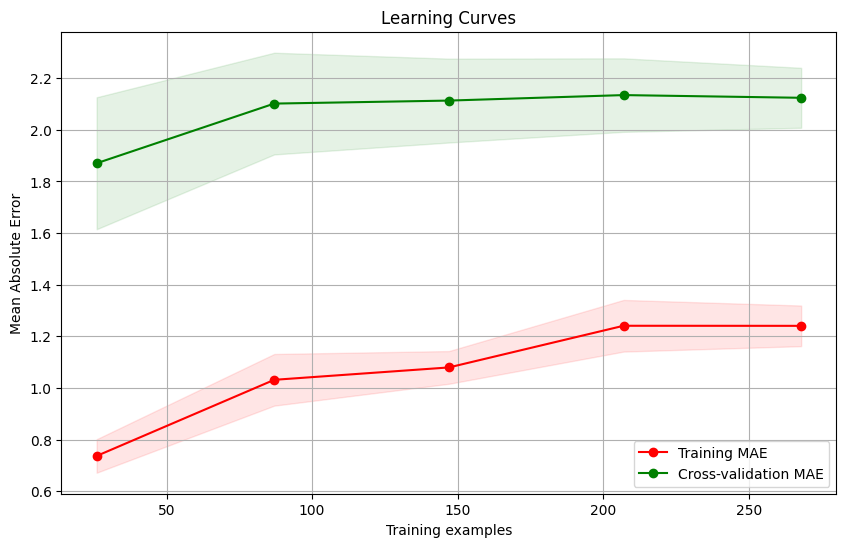

In [27]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# Since learning_curve works with scikit-learn estimators, wrap the model
estimator = KerasRegressor(build_fn=lambda: model, epochs=10, batch_size=32, verbose=0)
estimator.model = model

train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train_processed, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training MAE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation MAE")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


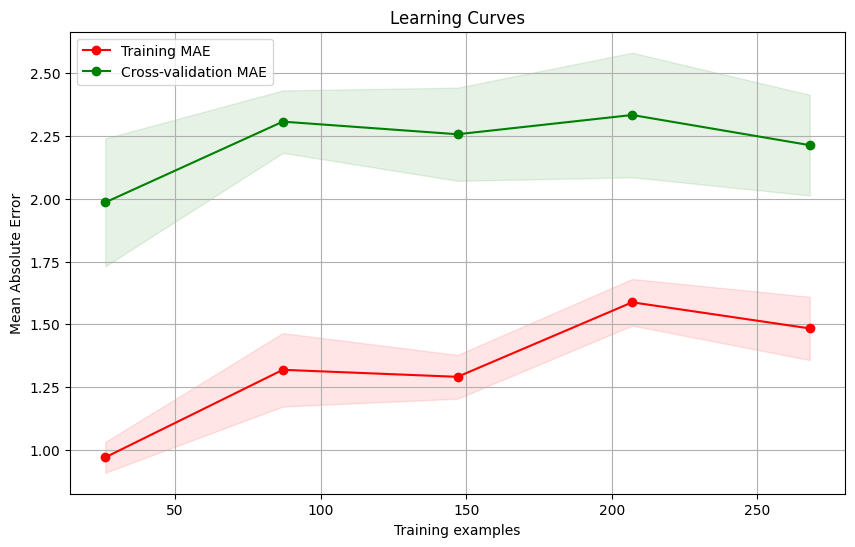

In [28]:
# Since learning_curve works with scikit-learn estimators, wrap the model
estimator_v2 = KerasRegressor(build_fn=lambda: model_v2, epochs=10, batch_size=32, verbose=0)
estimator_v2.model = model_v2

train_sizes_v2, train_scores_v2, test_scores_v2 = learning_curve(
    estimator_v2, X_train_processed, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calculate mean and standard deviation
train_scores_mean_v2 = -np.mean(train_scores_v2, axis=1)
train_scores_std_v2 = np.std(train_scores_v2, axis=1)
test_scores_mean_v2 = -np.mean(test_scores_v2, axis=1)
test_scores_std_v2 = np.std(test_scores_v2, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes_v2, train_scores_mean_v2 - train_scores_std_v2,
                 train_scores_mean_v2 + train_scores_std_v2, alpha=0.1, color="r")
plt.fill_between(train_sizes_v2, test_scores_mean_v2 - test_scores_std_v2,
                 test_scores_mean_v2 + test_scores_std_v2, alpha=0.1, color="g")
plt.plot(train_sizes_v2, train_scores_mean_v2, 'o-', color="r", label="Training MAE")
plt.plot(train_sizes_v2, test_scores_mean_v2, 'o-', color="g", label="Cross-validation MAE")
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate residuals
residuals = y_test - y_pred
residuals_v2 = y_test - y_pred_v2

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title('Residuals vs. Predicted Race Positions')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_v2, residuals_v2, alpha=0.7)
plt.title('Residuals vs. Predicted Race Positions')
plt.xlabel('Predicted Race Position')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
# Convert y_test and y_pred to DataFrames
y_test_df = y_test.reset_index(drop=True).to_frame(name='ActualRacePosition')
y_pred_df = pd.DataFrame(y_pred, columns=['PredictedRacePosition'])
y_pred_v2_df = pd.DataFrame(y_pred_v2, columns=['PredictedRacePosition'])


In [ ]:
# Get the original test features
X_test_original = X_test.reset_index(drop=True)

# Combine the data
results_df = pd.concat([X_test_original, y_test_df, y_pred_df], axis=1)
results_df_v2 = pd.concat([X_test_original, y_test_df, y_pred_v2_df], axis=1)

In [ ]:
# Extract driver and event information from the full dataset
full_data.reset_index(drop=True, inplace=True)

# Combine X and y
full_dataset = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

# Add driver and event information to the full dataset
full_dataset['DriverNumber'] = full_data['DriverNumber'].values
full_dataset['Abbreviation_Race'] = full_data['Abbreviation_Race'].values
full_dataset['EventName'] = full_data['EventName'].values

In [ ]:
# Extract the corresponding rows from the full dataset using test indices
test_info = full_dataset.iloc[test_idx].reset_index(drop=True)

# Combine the test info with the results
results_df = pd.concat(
    [test_info[['DriverNumber', 'Abbreviation_Race', 'EventName']].reset_index(drop=True),
     y_test.reset_index(drop=True).to_frame(name='ActualRacePosition'),
     pd.DataFrame(y_pred, columns=['PredictedRacePosition']).reset_index(drop=True)],
    axis=1
)

results_df_v2 = pd.concat(
    [test_info[['DriverNumber', 'Abbreviation_Race', 'EventName']].reset_index(drop=True),
     y_test.reset_index(drop=True).to_frame(name='ActualRacePosition'),
     pd.DataFrame(y_pred_v2, columns=['PredictedRacePosition']).reset_index(drop=True)],
    axis=1
)

In [ ]:
# Remove duplicate columns if any
results_df = results_df.loc[:, ~results_df.columns.duplicated()]
results_df_v2 = results_df_v2.loc[:, ~results_df_v2.columns.duplicated()]

In [ ]:
# Sort the results by EventName and ActualRacePosition
results_df.sort_values(['EventName'], inplace=True)
results_df_v2.sort_values(['EventName'], inplace=True)

# Display the table
print(results_df.to_string(index=False))
print(results_df_v2.to_string(index=False))


In [ ]:
# Get the list of unique events in the test set
events = results_df['EventName'].unique()

for event in events:
    # Filter data for the current event
    event_data = results_df[results_df['EventName'] == event]
    event_data_v2 = results_df_v2[results_df_v2['EventName'] == event]

    # Sort by actual race position
    event_data.sort_values('ActualRacePosition', inplace=True)
    event_data_v2.sort_values('ActualRacePosition', inplace=True)

    # Create a bar plot
    x = np.arange(len(event_data))  # Driver indices
    width = 0.25  # Adjusted width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width, event_data['ActualRacePosition'], width, label='Actual Position')  # Shifted left
    rects2 = ax.bar(x, event_data['PredictedRacePosition'], width, label='Predicted Position')  # Centered
    rects3 = ax.bar(x + width, event_data_v2['PredictedRacePosition'], width, label='Predicted Position V2')  # Shifted right

    # Add labels and titles
    ax.set_ylabel('Race Position')
    ax.set_title(f'Actual vs Predicted Race Positions - {event}')
    ax.set_xticks(x)
    ax.set_xticklabels(event_data['Abbreviation_Race'], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()
